# The MOMO data

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
import os
import sys
import glob
import time
import warnings
import datetime 
import matplotlib.dates as mdates
print("Last updated on ", time.asctime())

Last updated on  Tue May 19 11:03:07 2020


In [4]:
import numpy as np
import pandas as pd
import matplotlib

In [5]:
fontsize=20
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': fontsize,
        }

plt.rcParams["font.size"     ] = fontsize


In [6]:
from scipy.integrate import odeint
import scipy.integrate as spi
from scipy.interpolate import interp1d


In [7]:
from dataclasses import dataclass, field

In [8]:
from c19.types import SIR, SEIR

In [9]:
import c19.basic_models as cbm
import c19.core_functions as cf
import c19.plotting as cplt
import c19.utils as ut

In [164]:
from c19.data_functions_momo import get_data_momo
from c19.data_functions_momo import get_data_covid
from c19.data_functions_momo import select_df, select_ca, select_ccaa, select_date, select_date_ccaa
from c19.data_functions_momo import dict_excess_momo

In [167]:
from c19.momo_analysis import plot_momo, plot_momo_oe, plot_momo_ccaa, plot_momo_XY, plot_momo_XYS

# Read momo data (from url or update)

In [37]:
dm = get_data_momo(update=True)

Reading momo data from https://momo.isciii.es/public/momo/data
-- Done


In [38]:
dm.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-01,1010,1010.0,1010.0,1052.5,954.56,1131.300
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-02,940,940.0,940.0,1047.0,954.56,1150.965
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-03,1049,1049.0,1049.0,1048.0,954.56,1150.965
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-04,989,989.0,989.0,1050.0,954.56,1150.965
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-05,1035,1035.0,1035.0,1050.0,977.28,1150.965


In [100]:
dc.head()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
0,AN,20/2/2020,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,AR,20/2/2020,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,AS,20/2/2020,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,IB,20/2/2020,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,CN,20/2/2020,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [60]:
ccaa_code = ['AN','AR','AS','CN','CB','CM','CL','CT','EX','GA','IB','RI','MD','MC','NC','PV','VC','ML']
ccaa_name =['Andalucía', 'Aragón','Asturias','Canarias', 'Cantabria','Castilla-La Mancha','Castilla y León',
 'Catalunya', 'Extremadura', 'Galicia', 'Baleares','La Rioja','Madrid','Murcia','Navarra','Euskadi','C. Valenciana','Melilla']

YMOM = {'obs':'defunciones_observadas', 'esp':'defunciones_esperadas','esp99':'defunciones_esperadas_q99','esp01':'defunciones_esperadas_q01'}

In [45]:
dfm = select_ca(dm, ca_code='MD', cod_sexo='all', cod_gedad='all')

In [46]:
dfm.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
116844,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-01,119,119.0,119.0,109.5,91.295,135.155
116845,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-02,88,88.0,88.0,109.5,91.295,132.395
116846,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-03,113,113.0,113.0,108.0,91.295,138.445
116847,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-04,108,108.0,108.0,108.0,91.295,137.410
116848,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-05,98,98.0,98.0,108.5,91.295,137.410


In [101]:
dfcas = select_ccaa(dm, ccaa_code=ccaa_code, cod_sexo='all', cod_gedad='all')

In [104]:
dfcas.keys()

dict_keys(['AN', 'AR', 'AS', 'CN', 'CB', 'CM', 'CL', 'CT', 'EX', 'GA', 'IB', 'RI', 'MD', 'MC', 'NC', 'PV', 'VC', 'ML'])

In [105]:
dfcas['MD'].head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99
116844,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-01,119,119.0,119.0,109.5,91.295,135.155
116845,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-02,88,88.0,88.0,109.5,91.295,132.395
116846,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-03,113,113.0,113.0,108.0,91.295,138.445
116847,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-04,108,108.0,108.0,108.0,91.295,137.410
116848,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-05,98,98.0,98.0,108.5,91.295,137.410


In [109]:
dfs = select_df(dm,ambito='nacional', cod_sexo='all', cod_gedad='all')

In [110]:
df = select_date(dfs, date='2017-06-01')

In [111]:
df.head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99,npdate
0,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-01,1010,1010.0,1010.0,1052.5,954.56,1131.300,2018-05-01
1,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-02,940,940.0,940.0,1047.0,954.56,1150.965,2018-05-02
2,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-03,1049,1049.0,1049.0,1048.0,954.56,1150.965,2018-05-03
3,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-04,989,989.0,989.0,1050.0,954.56,1150.965,2018-05-04
4,nacional,NaN,NaN,NaN,all,todos,all,todos,2018-05-05,1035,1035.0,1035.0,1050.0,977.28,1150.965,2018-05-05


In [106]:
dfcasts = select_date_ccaa(dfcas, date='2017-06-01')

In [107]:
len(dfcasts)

18

In [108]:
dfcasts['MD'].head()

,ambito,cod_ambito,cod_ine_ambito,nombre_ambito,cod_sexo,nombre_sexo,cod_gedad,nombre_gedad,fecha_defuncion,defunciones_observadas,defunciones_observadas_lim_inf,defunciones_observadas_lim_sup,defunciones_esperadas,defunciones_esperadas_q01,defunciones_esperadas_q99,npdate
116844,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-01,119,119.0,119.0,109.5,91.295,135.155,2018-05-01
116845,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-02,88,88.0,88.0,109.5,91.295,132.395,2018-05-02
116846,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-03,113,113.0,113.0,108.0,91.295,138.445,2018-05-03
116847,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-04,108,108.0,108.0,108.0,91.295,137.410,2018-05-04
116848,ccaa,MD,13.0,"Madrid, Comunidad de",all,todos,all,todos,2018-05-05,98,98.0,98.0,108.5,91.295,137.410,2018-05-05


# Observed, expected

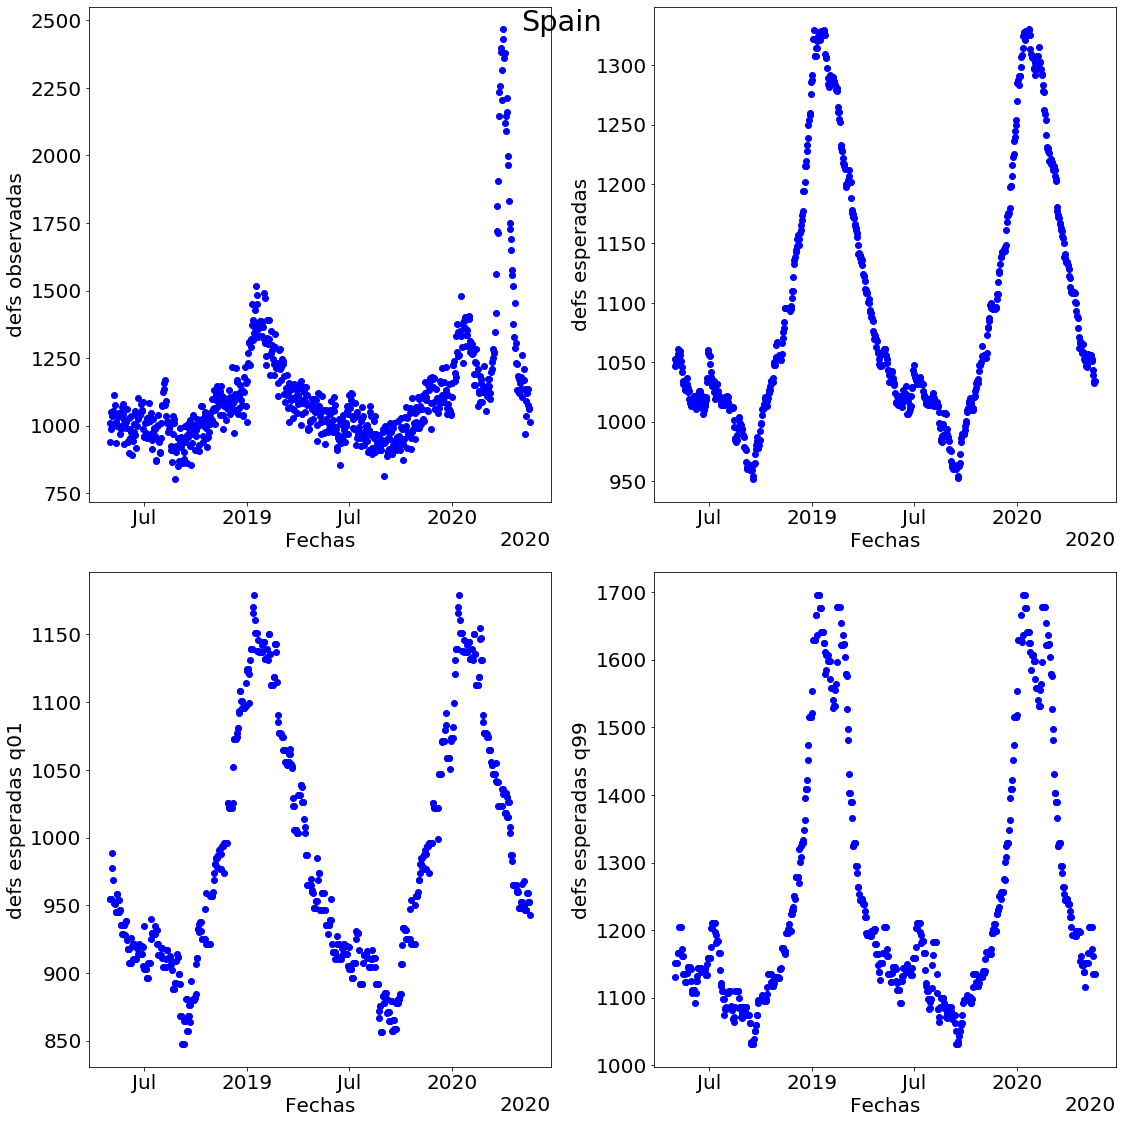

In [172]:
plot_momo_oe(df, ccaa='Spain', figsize=(16,16))

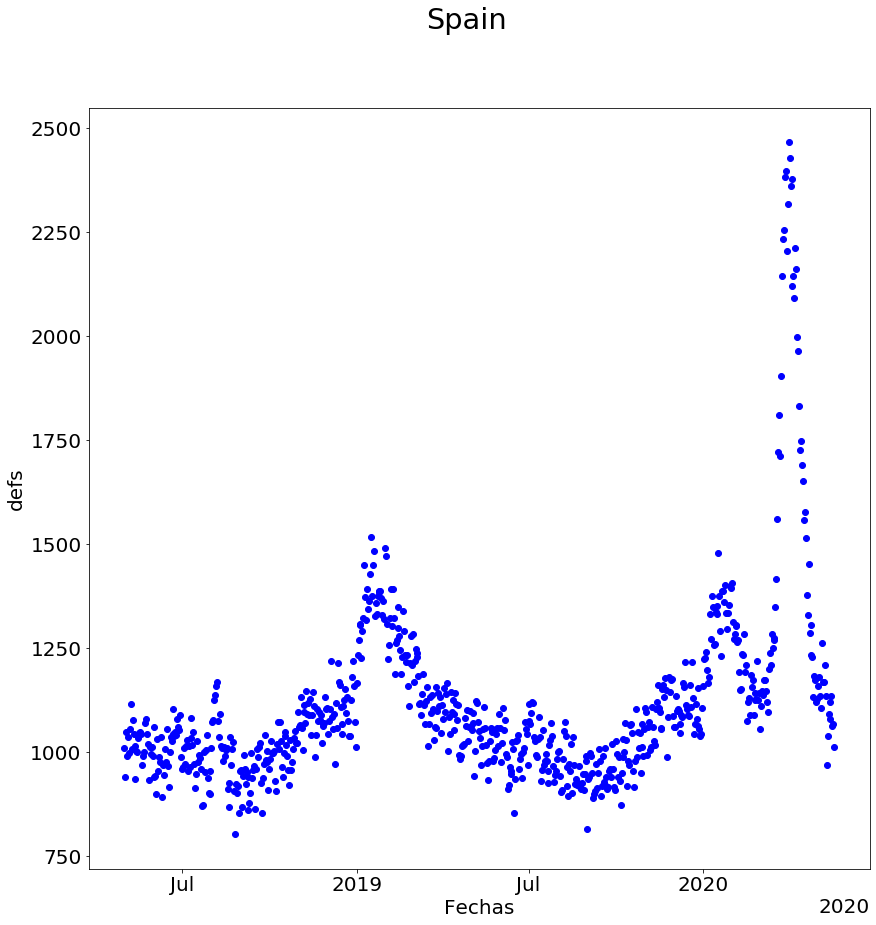

In [173]:
plot_momo(df, ydata='defunciones_observadas', ccaa='Spain', figsize=(14,14))

In [174]:
tD,tS,Yobs = get_mdata(df, ydata=YMOM['obs'], ccaa='Spain')

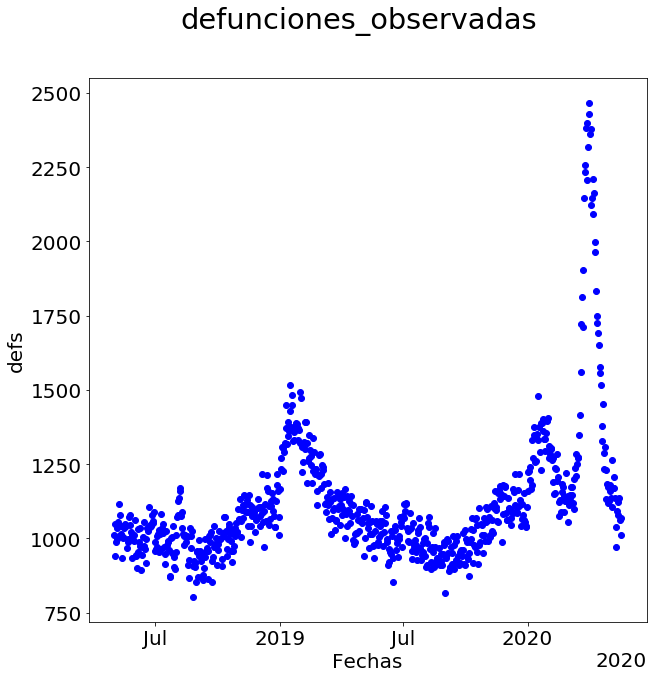

In [180]:
plot_momo_XY(tD, tS, Yobs, tCase='tD', yCase=YMOM['obs'], figsize=(10,10))

In [177]:
tD,tS,Yesp = get_mdata(df, ydata=YMOM['esp'], ccaa='Spain')

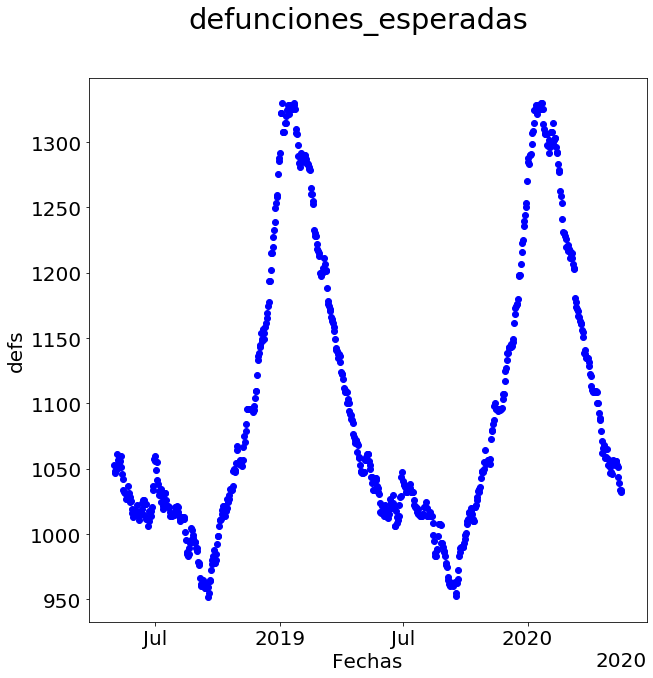

In [179]:
plot_momo_XY(tD, tS, Yesp, tCase='tD', yCase=YMOM['esp'], figsize=(10,10))

In [181]:
tD,tS,Yesp01 = get_mdata(df, ydata=YMOM['esp01'], ccaa='Spain')

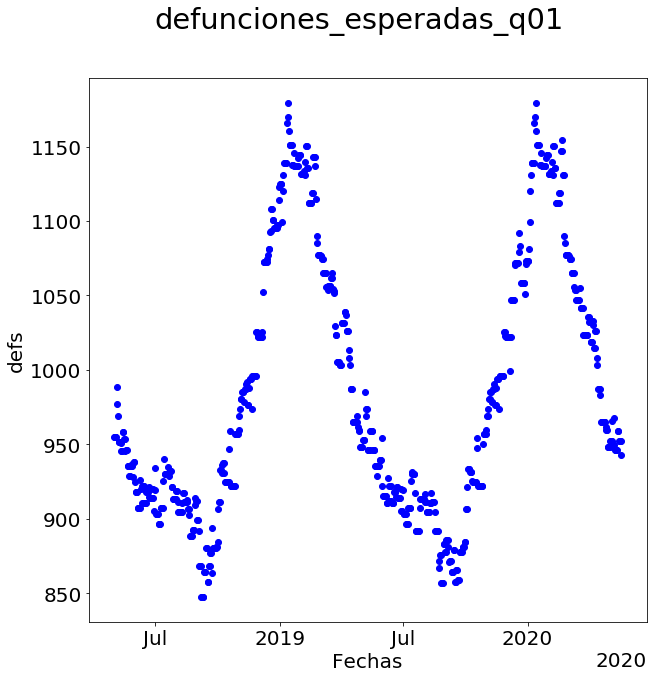

In [182]:
plot_momo_XY(tD, tS, Yesp01, tCase='tD', yCase=YMOM['esp01'], figsize=(10,10))

In [183]:
tD,tS,Yesp99 = get_mdata(df, ydata=YMOM['esp99'], ccaa='Spain')

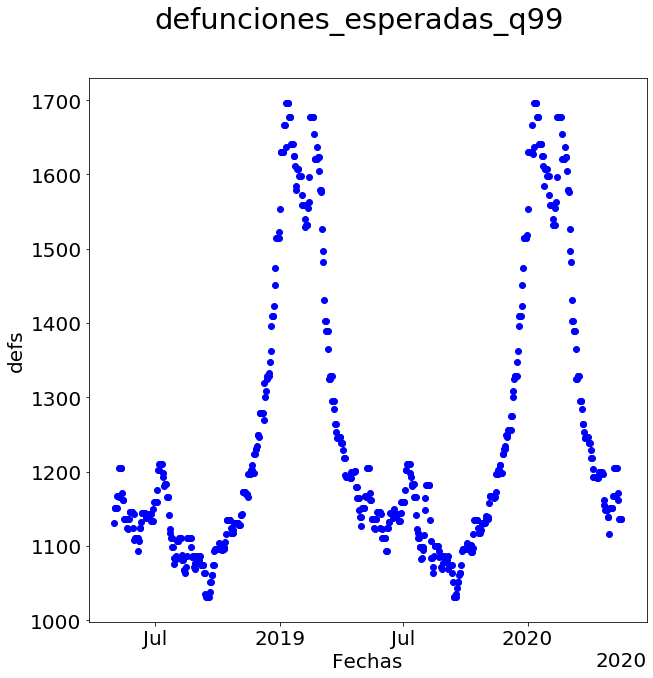

In [184]:
plot_momo_XY(tD, tS, Yesp99, tCase='tD', yCase=YMOM['esp99'], figsize=(10,10))

In [185]:
Y = Yobs - Yesp
Y01 = Yobs - Yesp01
Y99 = Yobs - Yesp99

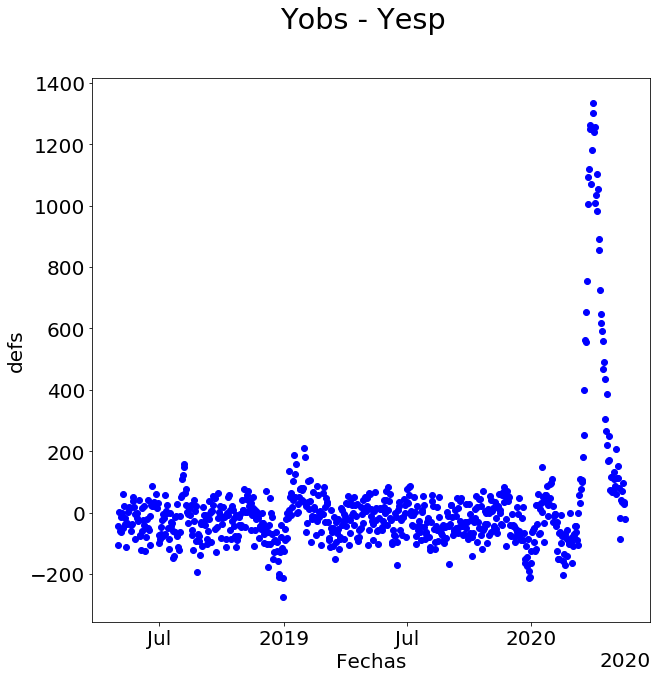

In [186]:
plot_momo_XY(tD, tS, Y, tCase='tD', yCase='Yobs - Yesp', figsize=(10,10))

In [187]:
tD,tS,dYobs = get_mdata_ccaa(dfcasts, ydata=YMOM['obs'])

In [188]:
tD,tS,dYesp = get_mdata_ccaa(dfcasts, ydata=YMOM['esp'])

In [189]:
dY = dict_excess_momo(dYobs, dYesp)

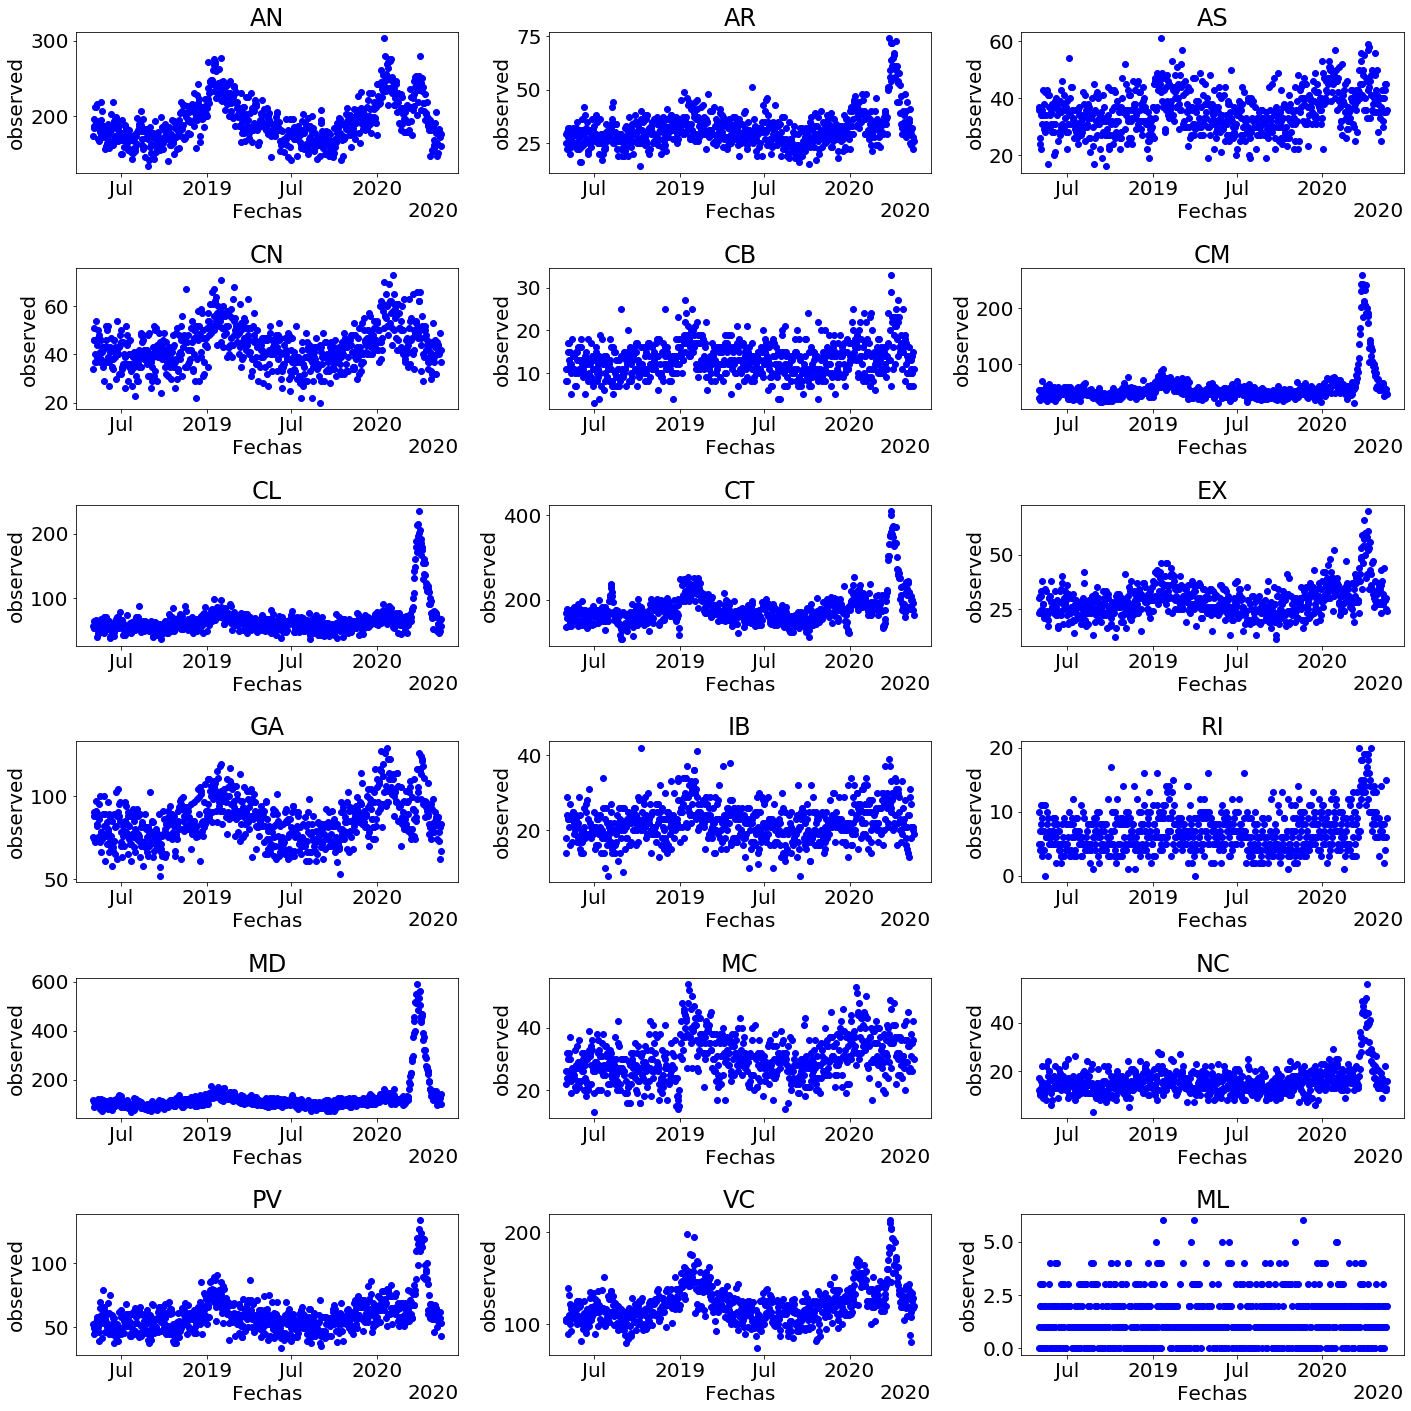

In [193]:
plot_momo_XYS(tD, tS, dYobs, tCase='tD', yCase='observed', figsize=(20,20))

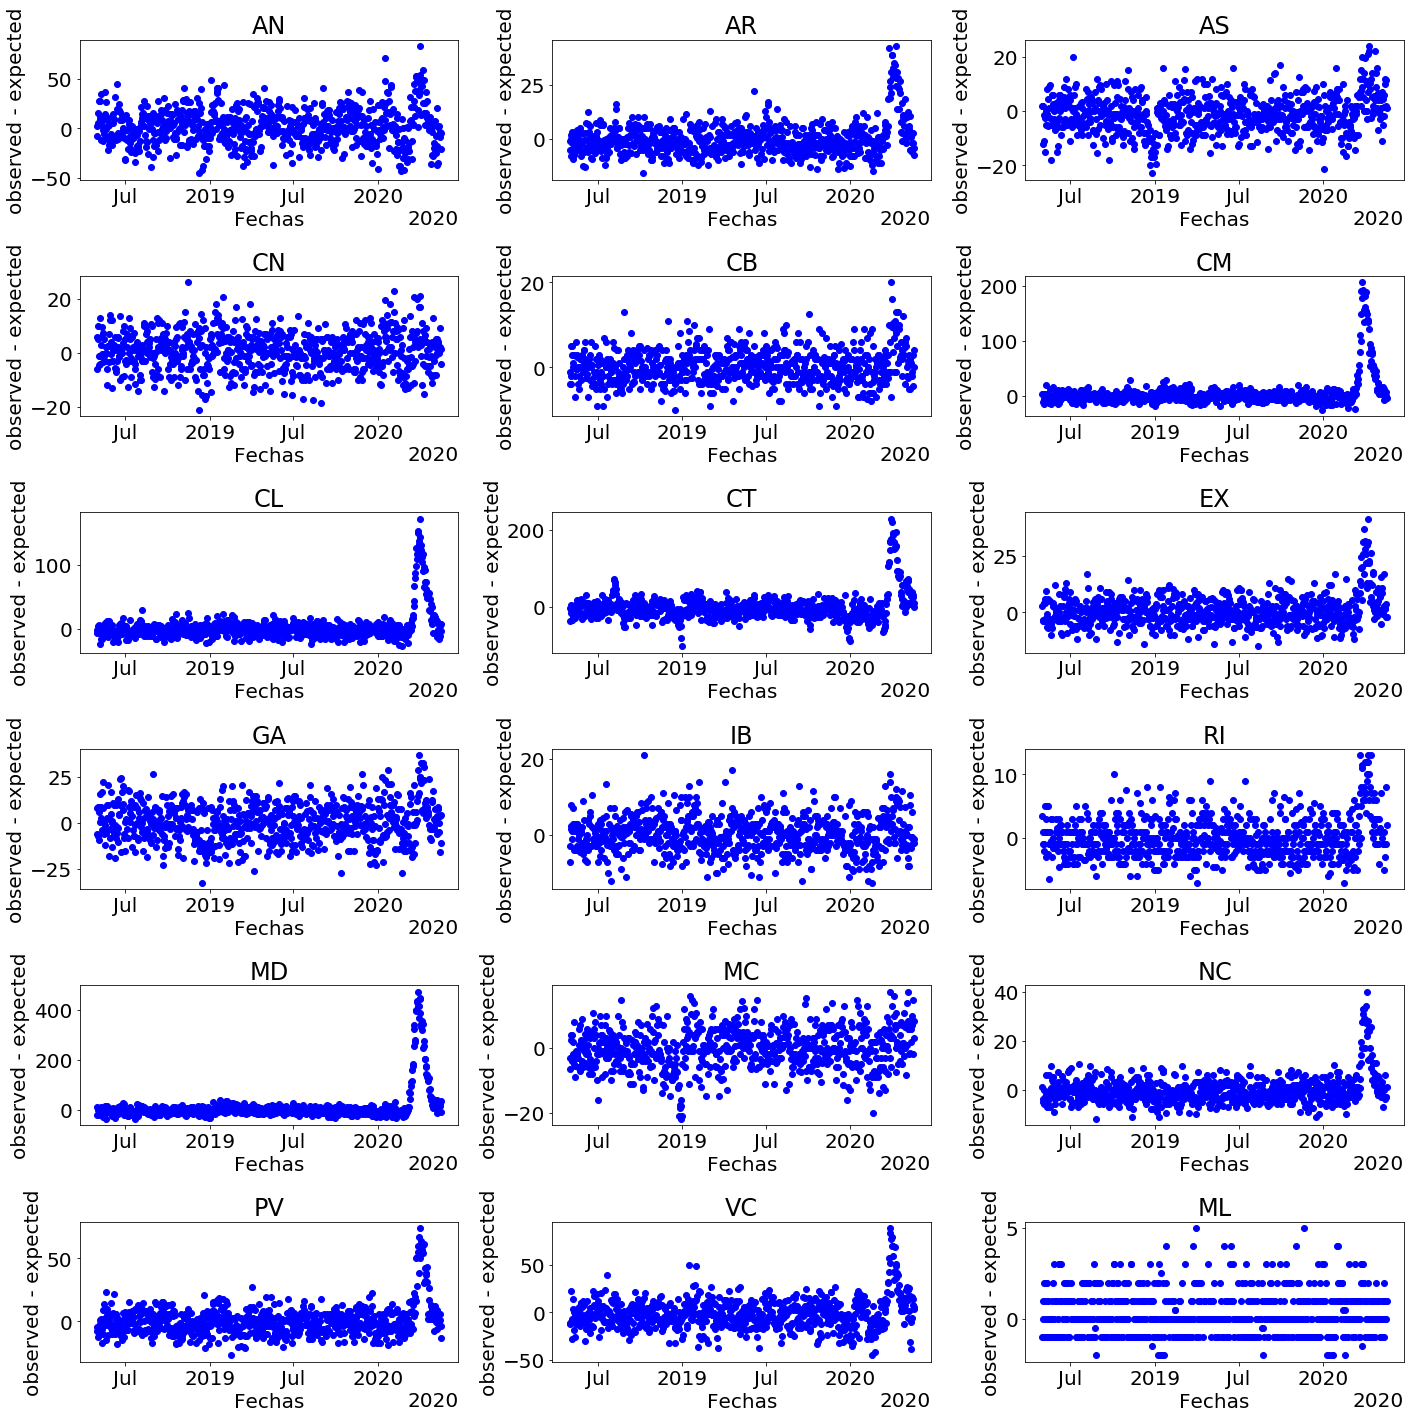

In [195]:
plot_momo_XYS(tD, tS, dY, tCase='tD', yCase='observed - expected', figsize=(20,20))

In [196]:
dfc2020 = select_date_ccaa(dfcas, date='2020-01-01')

In [199]:
tD,tS,dYobs   = get_mdata_ccaa(dfc2020, ydata=YMOM['obs'])
tD,tS,dYesp   = get_mdata_ccaa(dfc2020, ydata=YMOM['esp'])
tD,tS,dYesp01 = get_mdata_ccaa(dfc2020, ydata=YMOM['esp01'])
tD,tS,dYesp99 = get_mdata_ccaa(dfc2020, ydata=YMOM['esp99'])

In [203]:
dY = dict_excess_momo(dYobs, dYesp)
dY01 = dict_excess_momo(dYobs, dYesp01)
dY99 = dict_excess_momo(dYobs, dYesp99)

In [213]:
dYvar = dict_excess_momo(dY01, dY99)

## Observed - Expected

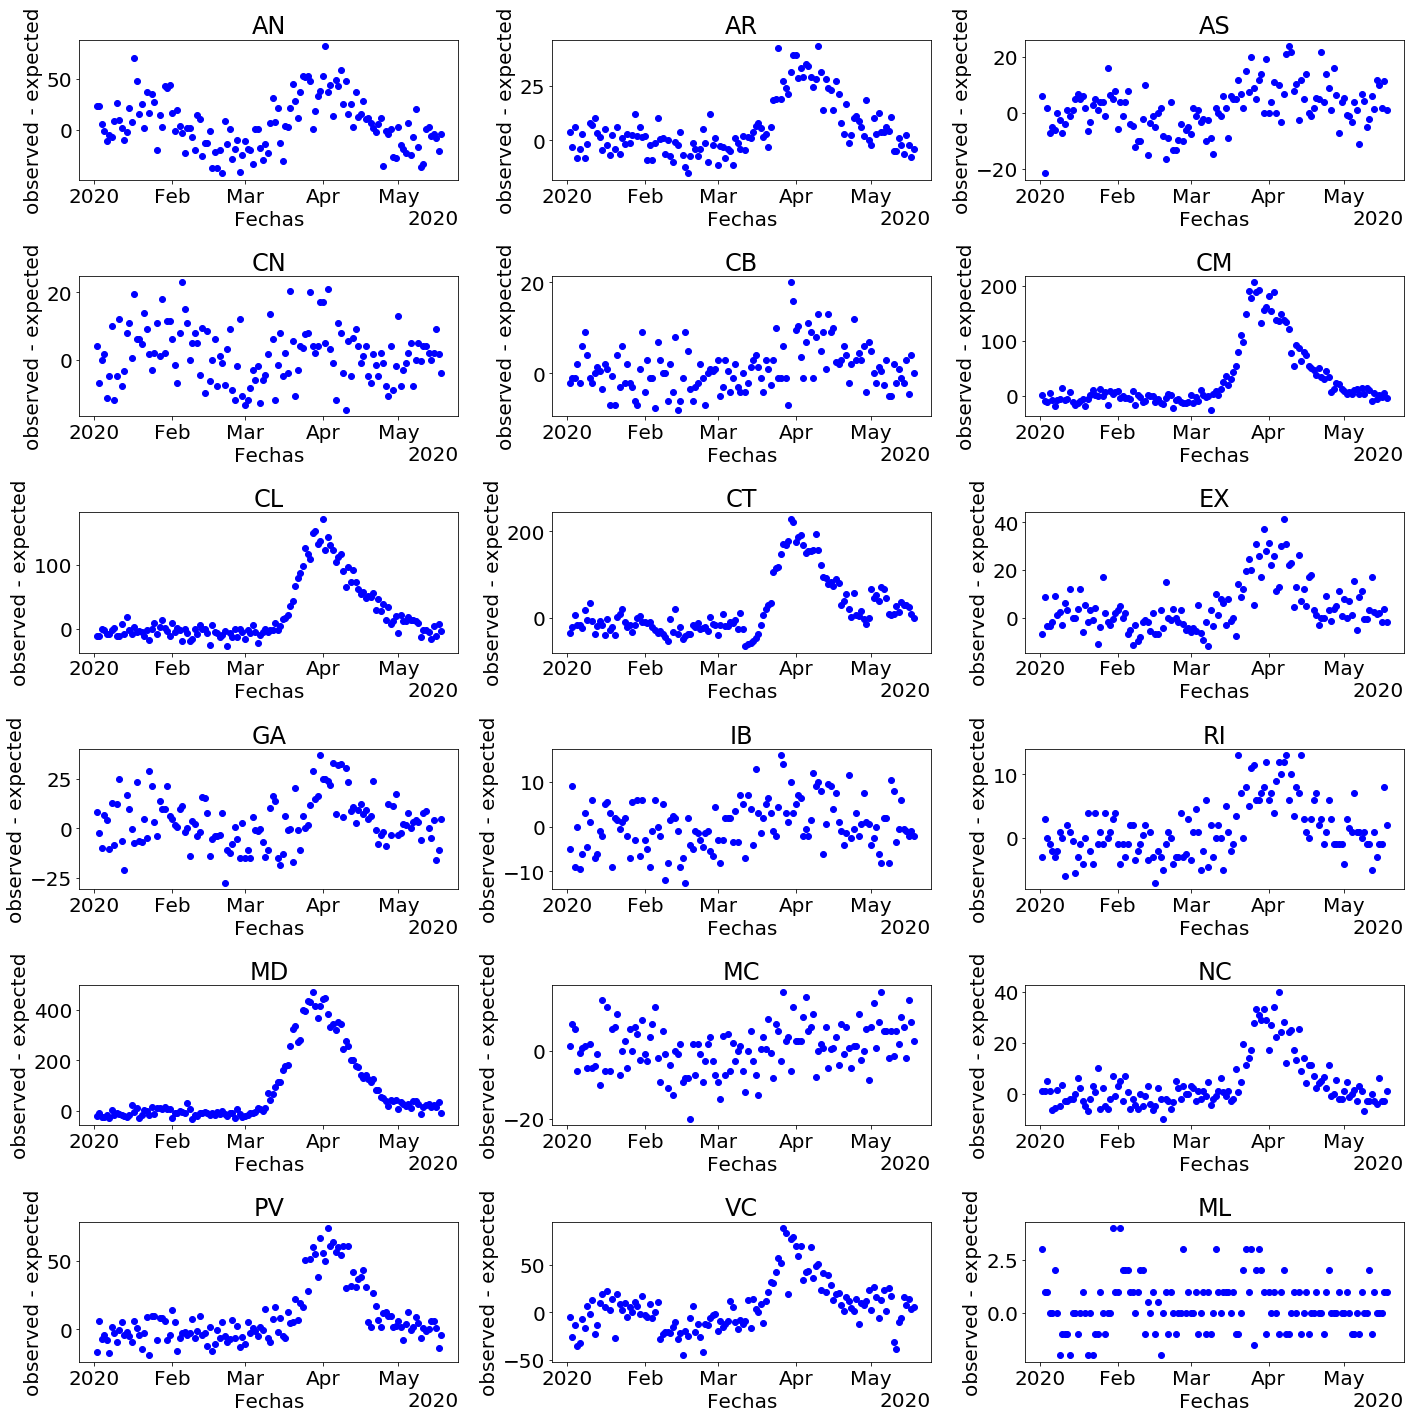

In [198]:
plot_momo_XYS(tD, tS, dY, tCase='tD', yCase='observed - expected', figsize=(20,20))

## Observed - Expected 1 %

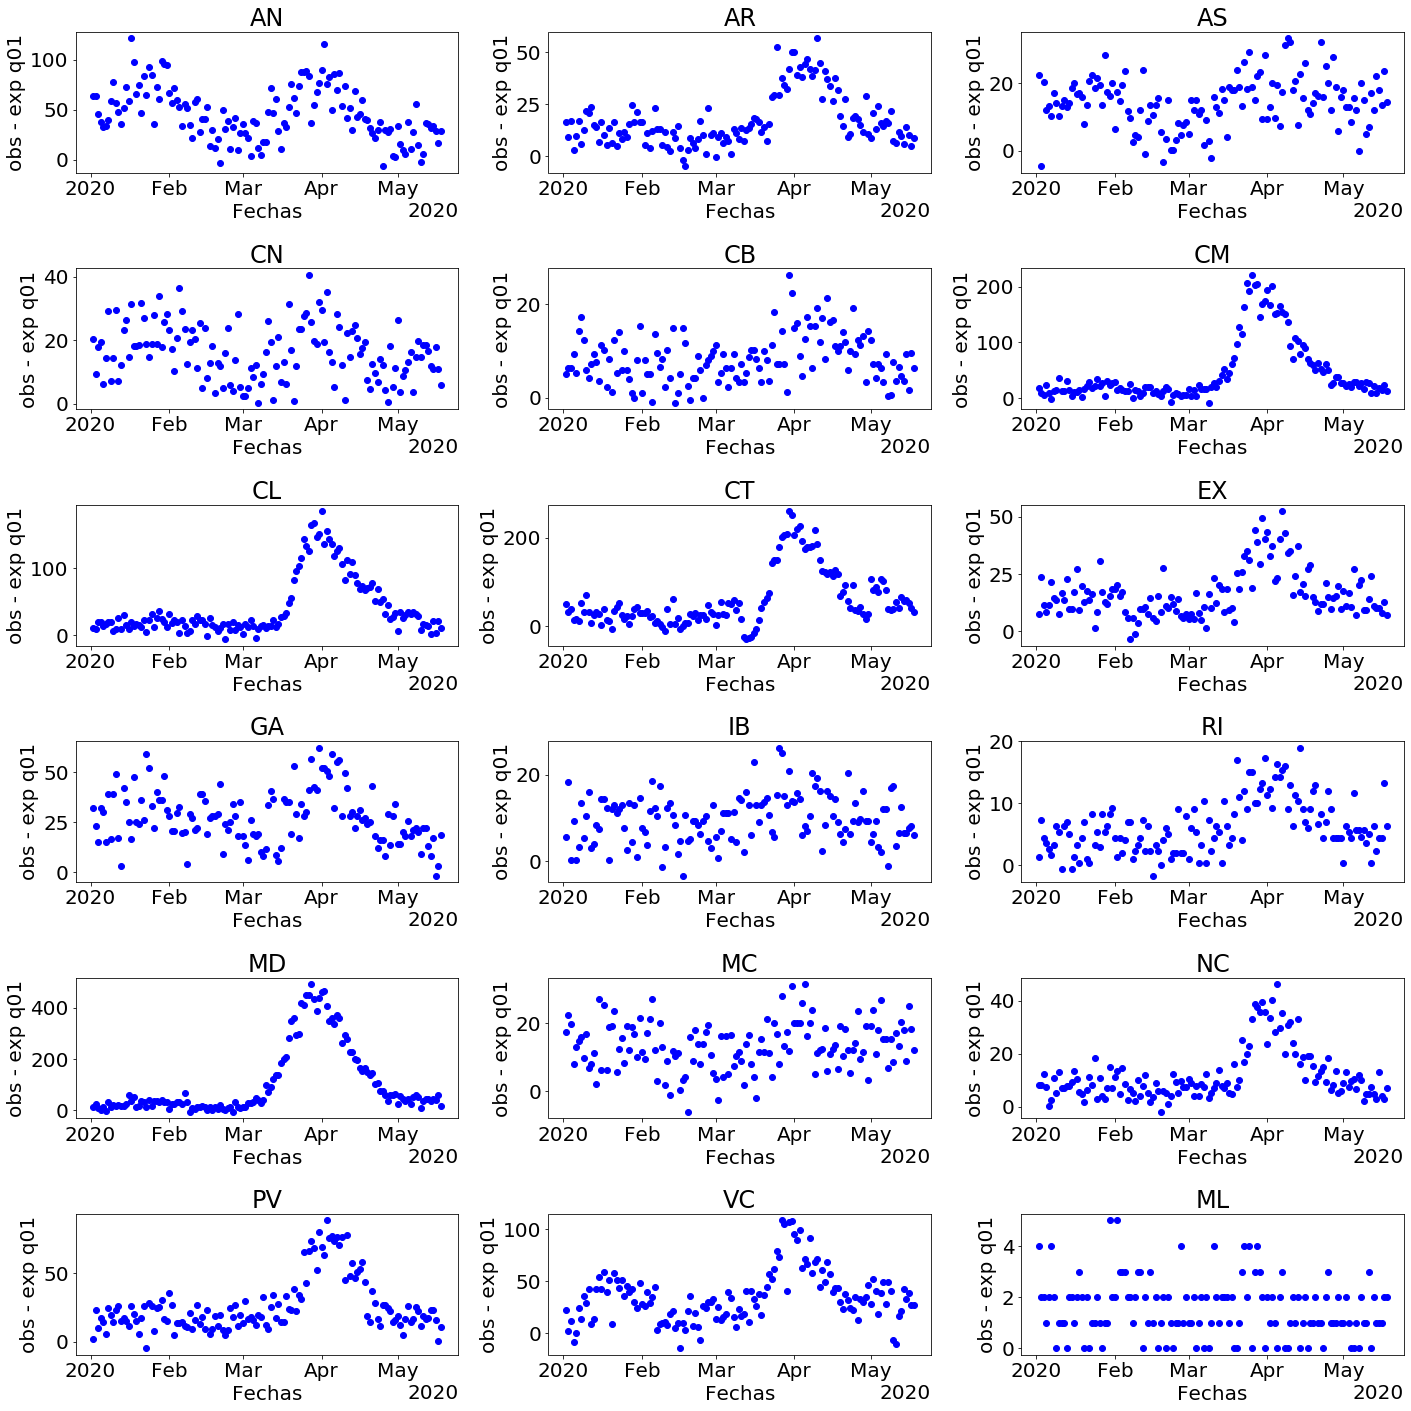

In [209]:
plot_momo_XYS(tD, tS, dY01, tCase='tD', yCase='obs - exp q01', figsize=(20,20))

## Observed - Expected 99%

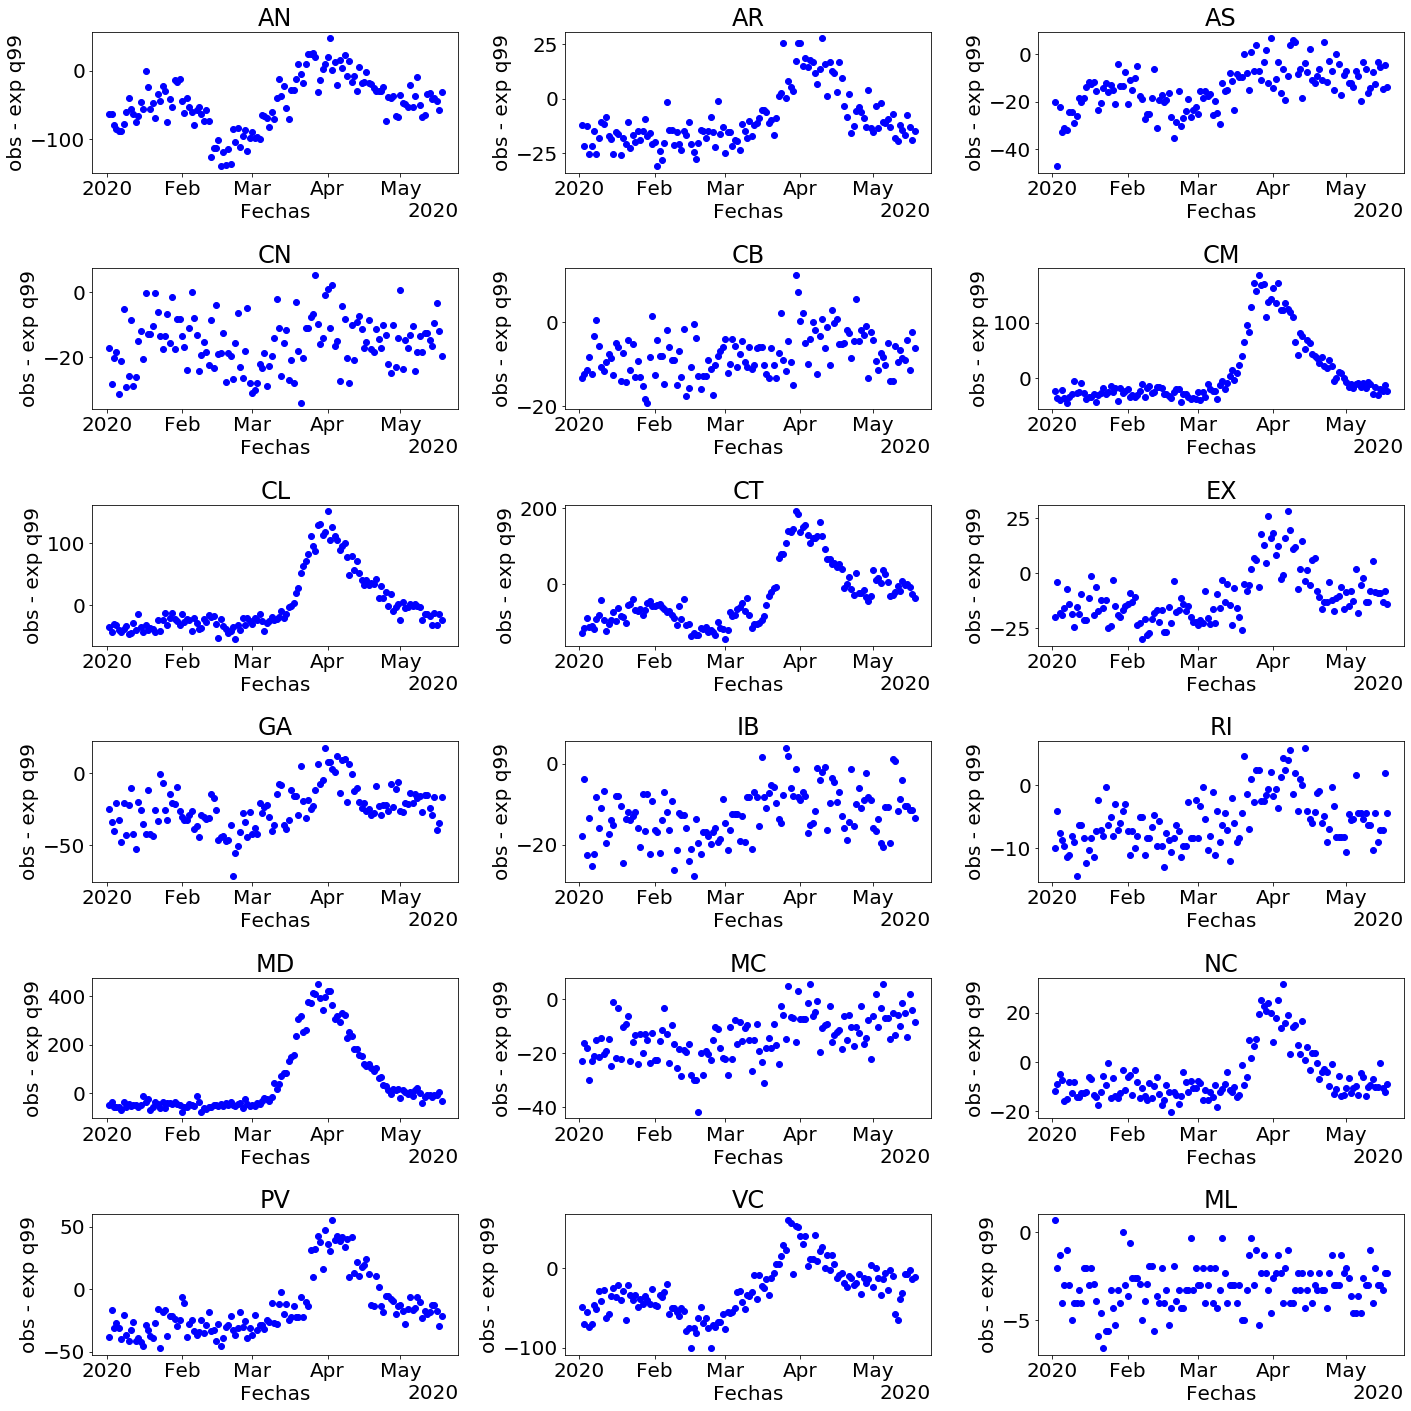

In [210]:
plot_momo_XYS(tD, tS, dY99, tCase='tD', yCase='obs - exp q99', figsize=(20,20))

## Double subtraction

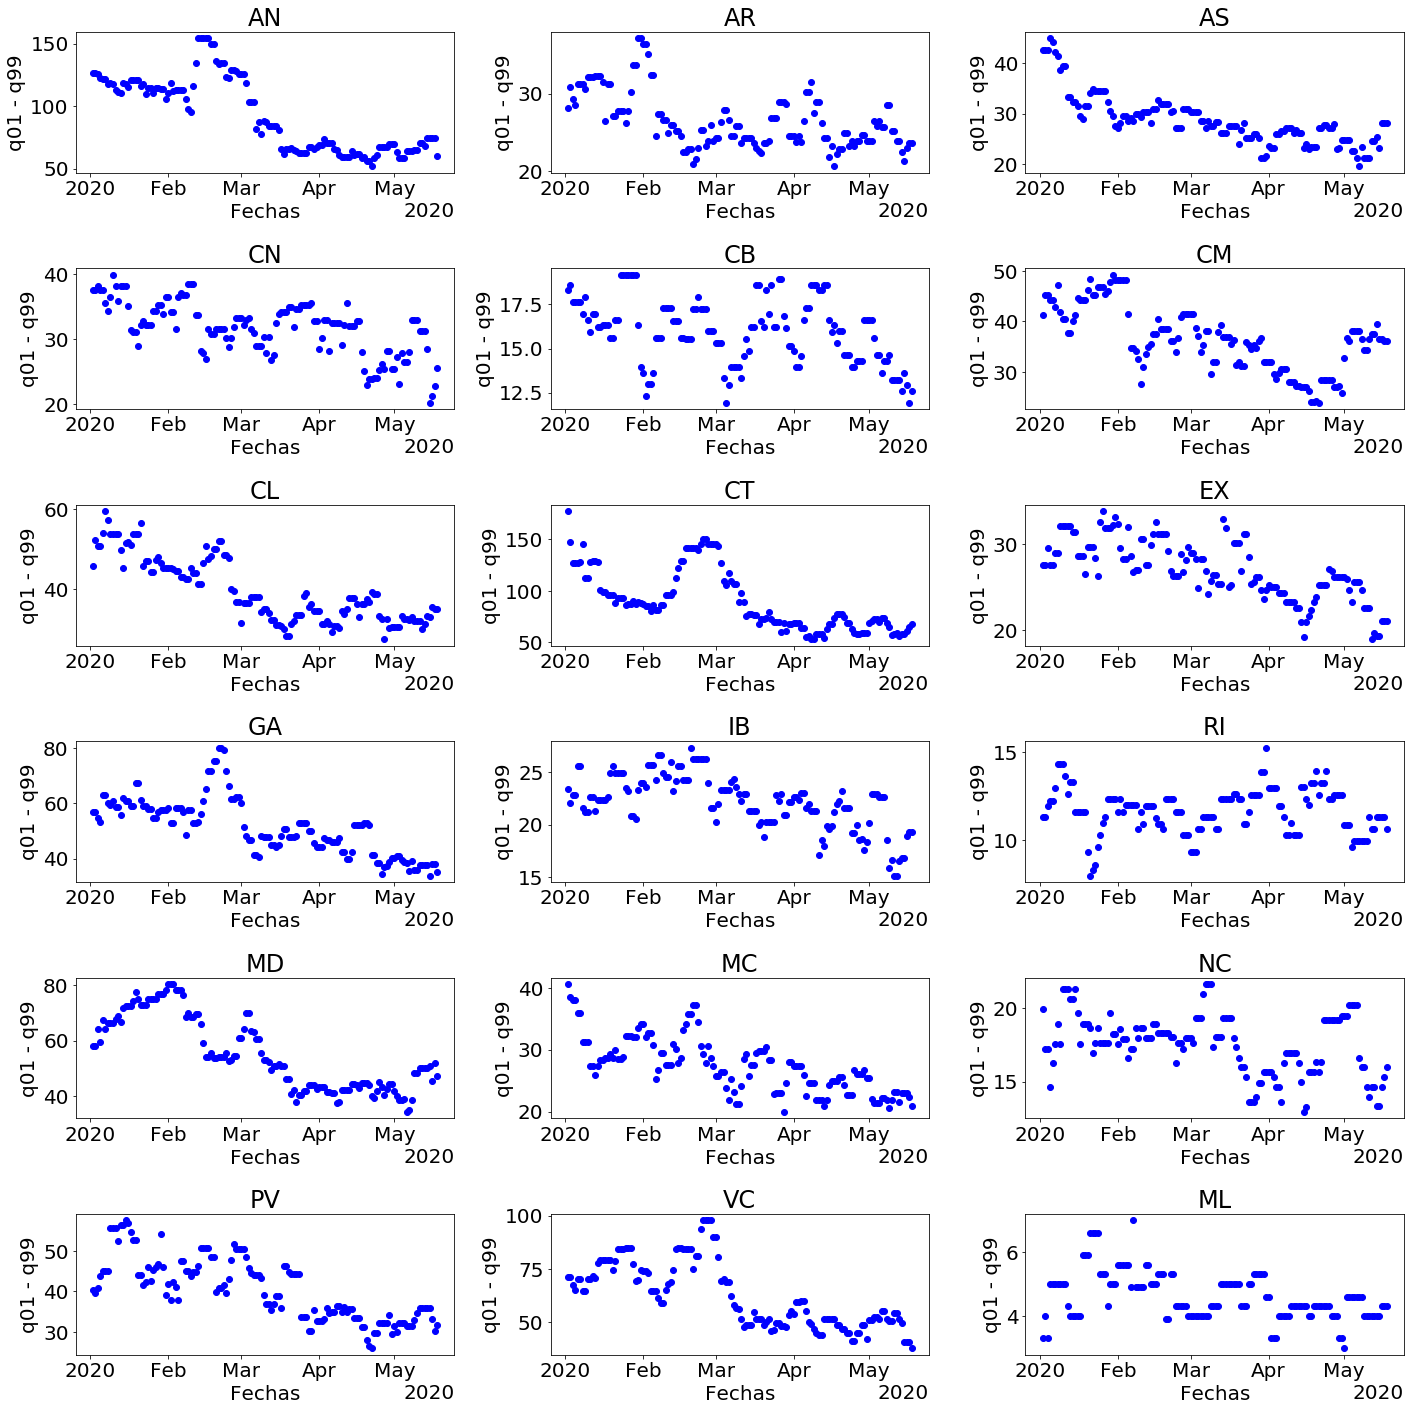

In [214]:
plot_momo_XYS(tD, tS, dYvar, tCase='tD', yCase='q01 - q99', figsize=(20,20))

## Read IsCIII COVID data

In [243]:
dc = get_data_covid(update=True)

Reading covid data from https://cnecovid.isciii.es/covid19/resources/agregados.csv
-- Done


In [248]:
dc.head()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
0,AN,20/2/2020,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,AR,20/2/2020,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,AS,20/2/2020,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,IB,20/2/2020,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,CN,20/2/2020,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [315]:
def isc3cov_get_data(dc):
    dates = dc['FECHA'].values
    dead  = dc['Fallecidos'].values
    ccaa  = dc['CCAA'].values
    npdates = []
    cdead   = []
    
    CCAA    = []
    dp, mp, yp = 0, 0, 0
    d0 = 0
    for i, d in enumerate(dates):
        if type(d) != str:
            break
        else:
            day, month, year = d.split("/")  
            dp, mp, yp = day, month, year
            dt = datetime.datetime(int(year), int(month), int(day))
            npdates.append(np.datetime64(dt))
            cdead.append(dead[i])
            CCAA.append(ccaa[i])
            d0 = dead[i]
    return pd.DataFrame({"ccaa":CCAA, "date":npdates, "cdead":cdead}).dropna()
    #return dc


In [342]:
df = isc3cov_get_data(dc)

In [343]:
df.head()

,ccaa,date,cdead
323,AN,2020-03-08,0.0
324,AR,2020-03-08,3.0
325,AS,2020-03-08,0.0
326,IB,2020-03-08,0.0
327,CN,2020-03-08,0.0


In [348]:
def isc3cov_select_ca_and_compute_xdead(dm, ca_code='MD'):
    df    = dm.loc[dm.ccaa == ca_code, ('ccaa', 'date','cdead')]
    dead  = df['cdead'].values
    xdead = []
    d0 = 0
    for d in dead:
        xdead.append(d - d0)
        d0 = d
    
    df['dead'] = xdead
    return df

In [367]:
dfm = isc3cov_select_ca_and_compute_xdead(df,ca_code='MD')

In [368]:
dfm.head()

,ccaa,date,cdead,dead
336,MD,2020-03-08,16.0,16.0
355,MD,2020-03-09,21.0,5.0
374,MD,2020-03-10,31.0,10.0
393,MD,2020-03-11,56.0,25.0
412,MD,2020-03-12,81.0,25.0


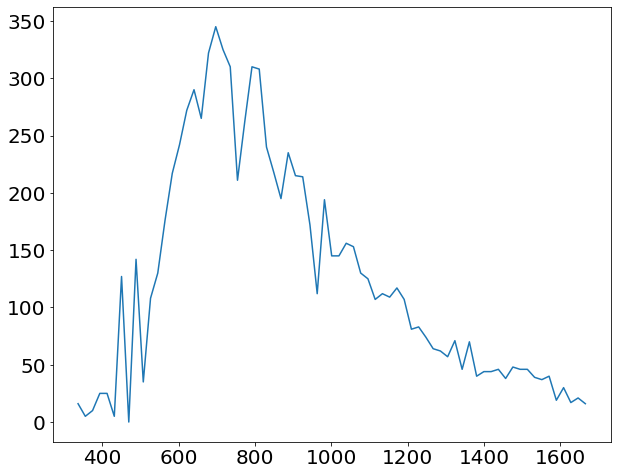

In [369]:
plt.plot(dfm.index, dfm.dead)


In [356]:
url_c19_files      = "https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019"
c19_file_deaths    = "ccaa_covid19_fallecidos.csv"
import urllib

In [357]:
urllib.request.urlretrieve ("{}/{}".format(url_c19_files,c19_file_deaths), c19_file_deaths)

('ccaa_covid19_fallecidos.csv', <http.client.HTTPMessage at 0x1a2903ddd0>)

In [358]:
cdf = pd.read_csv(c19_file_deaths)

In [377]:
dfm2 = cdf.loc[cdf.CCAA == "Madrid"].T

In [378]:
dfm2.head()

,13
cod_ine,13
CCAA,Madrid
2020-03-03,0
2020-03-04,0
2020-03-05,1


In [379]:
dm2.index

RangeIndex(start=0, stop=179760, step=1)

In [373]:
plt.plot(dfm2.index, dfm2.Madrid)


AttributeError: 'DataFrame' object has no attribute 'Madrid'

In [363]:
cdf['Madrid']

KeyError: 'Madrid'

In [ ]:
url_c19_files      = "https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019"
c19_file_deaths    = "ccaa_covid19_fallecidos.csv"

def get_data_communities(api_key, datapath="../data/data_communities.csv", update=False):
    urllib.request.urlretrieve ("{}/{}".format(url_c19_files,c19_file_deaths), c19_file_deaths)
    # If we're just reading (not updating) the data, just read it from the CSV.
    if(not update):
        if(not os.path.isfile(datapath)):
            print("File",datapath,"does not exist. Run this function with update=True to retrieve the data.")
            return None
        cdf = pd.read_csv(datapath)
        cdf.drop("Unnamed: 0", axis=1, inplace=True)
        cdf['dateRep'] = pd.to_datetime(cdf['dateRep'], format="%Y-%m-%d")
        return cdf

In [241]:
dct = isc3cov_set_standard_datetime(dc)

found nan: previous date = 2020/5/17
found nan: previous date = 2020/5/17
found nan: previous date = 2020/5/17
found nan: previous date = 2020/5/17
found nan: previous date = 2020/5/17
found nan: previous date = 2020/5/17
found nan: previous date = 2020/5/17
found nan: previous date = 2020/5/17
